In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import tinycudann as tcnn

/home/sfk/miniconda3/envs/py38torch/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = torch.load('../logs/sh/lego_rank10_sh28_init0.5highlr/model.pth')
model['model'].keys()
F = model['model']['features']
F.shape

torch.Size([28, 6, 6, 6, 6, 6])

In [44]:
direction_encoder = tcnn.Encoding(
            n_input_dims=3,
            encoding_config={
                "otype": "SphericalHarmonics",
                "degree": 3,
            },
        )
sh_mult = direction_encoder(torch.zeros(1,3).cuda()).cpu().detach().numpy()  # [1, 9]
print(sh_mult)





[[ 0.282   0.4885 -0.4885  0.4885  1.093  -1.093   0.631  -1.093   0.    ]]


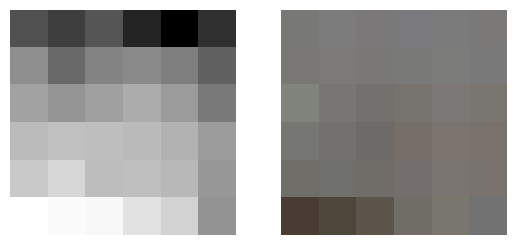

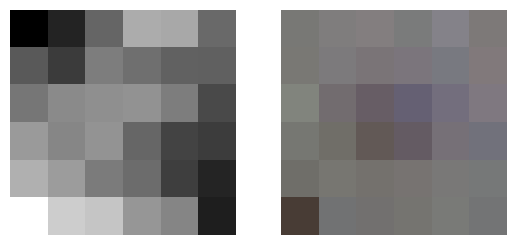

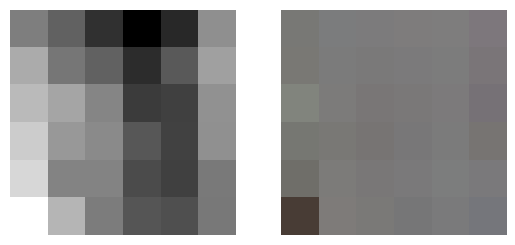

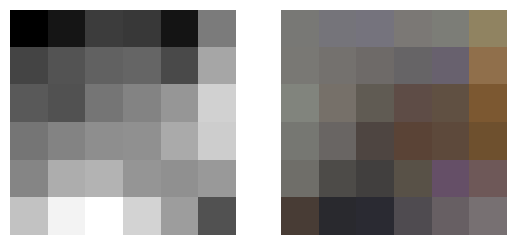

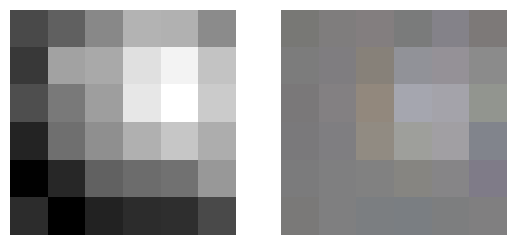

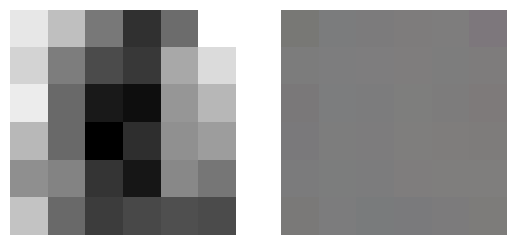

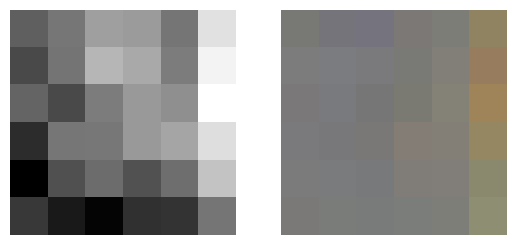

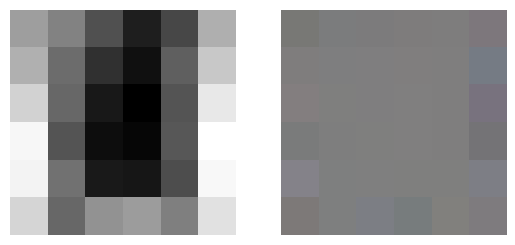

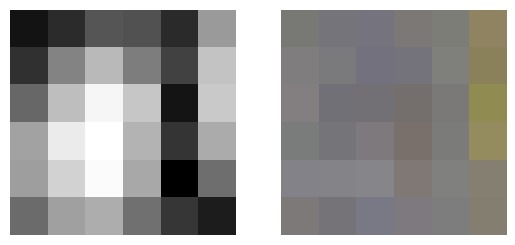

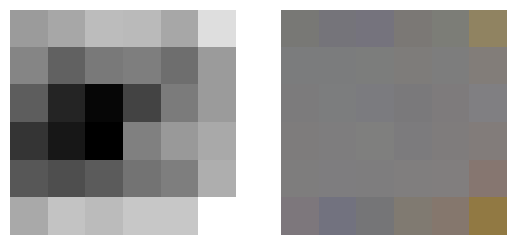

In [45]:
def visualize_slice(F, sh_mult, coords):
    # If coords are the ones we want to keep, construct the ones we want to not keep
    assert len(coords) == 2
    assert not (0 in coords)
    uncoords = [0,1,2,3,4,5]
    uncoords = [i for i in uncoords if not (i in coords)]
    # slice F according to the coordinates
    Fslice = F.cpu().numpy()
    Fslice = np.take(Fslice, 0, axis=uncoords[3])
    Fslice = np.take(Fslice, 0, axis=uncoords[2])
    Fslice = np.take(Fslice, 0, axis=uncoords[1])
    # visualize sigma (last entry) and the zero degree harmonics (reshape into 3 by 9, then take first set of 3 as rgb)
    sigma = Fslice[-1,:,:]
    rgb = Fslice[0:-1].reshape(3, -1, 6, 6)
    # rgb = np.sum(rgb * sh_mult[:,:,None,None], axis=1)
    rgb = rgb * sh_mult[:,:,None,None]
    rgb = rgb[:,0,:,:]
    rgb = torch.sigmoid(torch.from_numpy(rgb)).numpy()
    rgb = rgb.transpose(1,2,0)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(sigma, cmap='gray')
    ax[0].set_axis_off()
    ax[1].imshow(rgb)
    ax[1].set_axis_off()
    plt.show()
    


visualize_slice(F, sh_mult, coords=[1,2])
visualize_slice(F, sh_mult, coords=[1,3])
visualize_slice(F, sh_mult, coords=[1,4])
visualize_slice(F, sh_mult, coords=[1,5])
visualize_slice(F, sh_mult, coords=[2,3])
visualize_slice(F, sh_mult, coords=[2,4])
visualize_slice(F, sh_mult, coords=[2,5])
visualize_slice(F, sh_mult, coords=[3,4])
visualize_slice(F, sh_mult, coords=[3,5])
visualize_slice(F, sh_mult, coords=[4,5])

## Visualize ray sampling


when my range is 2 to 10, the first delta is 0.007345676422119141 and the second is 0.007372856140136719, with ratio 1.0037001371383667
when my range is 2 to 6, the first delta is 0.005011558532714844 and the second is 0.0050237178802490234, with ratio 1.002426266670227


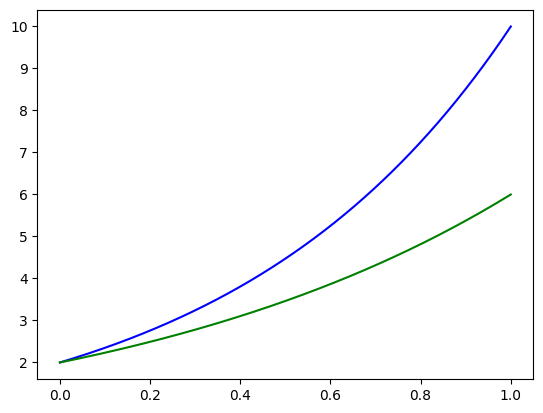

In [40]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
def genspace(start, stop, num, fn, inv_fn):
    """A generalization of linspace(), geomspace(), and NeRF's "lindisp".
    Behaves like jnp.linspace(), except it allows an optional function that
    "curves" the values to make the spacing between samples not linear.
    If no `fn` value is specified, genspace() is equivalent to jnp.linspace().
    If fn=jnp.log, genspace() is equivalent to jnp.geomspace().
    If fn=jnp.reciprocal, genspace() is equivalent to NeRF's "lindisp".
    Args:
    start: float tensor. The starting value of each sequence.
    stop: float tensor. The end value of each sequence.
    num: int. The number of samples to generate for each sequence.
    fn: function. A jnp function handle used to curve `start`, `stop`, and the
      intermediate samples.
    Returns:
    A tensor of length `num` spanning [`start`, `stop`], according to `fn`.
    """
    # Linspace between the curved start and stop values.
    t = torch.linspace(0., 1., num)
    s = fn(start) * (1. - t) + fn(stop) * t

    # Apply `inv_fn` and clamp to the range of valid values.
    return torch.clip(inv_fn(s), torch.minimum(start, stop), torch.maximum(start, stop))

num = 440
gamma = torch.Tensor([1.5])
x = torch.linspace(0., 1., num)
y = genspace(torch.Tensor([2]), torch.Tensor([10]), num, torch.log, torch.exp)
plt.plot(x, y, c='blue')
print(f'when my range is 2 to 10, the first delta is {y[1] - y[0]} and the second is {y[2]-y[1]}, with ratio {(y[2]-y[1]) / (y[1] - y[0])}')

x = torch.linspace(0., 1., num)
y = genspace(torch.Tensor([2]), torch.Tensor([6]), num, lambda a: torch.log(a)/torch.log(gamma), lambda a: gamma ** a)
plt.plot(x, y, c='green')
print(f'when my range is 2 to 6, the first delta is {y[1] - y[0]} and the second is {y[2]-y[1]}, with ratio {(y[2]-y[1]) / (y[1] - y[0])}')

# x = torch.linspace(0., 1., num)
# y = genspace(torch.Tensor([0.1]), torch.Tensor([200]), num, torch.reciprocal, torch.reciprocal)
# plt.plot(x, y, c='red')

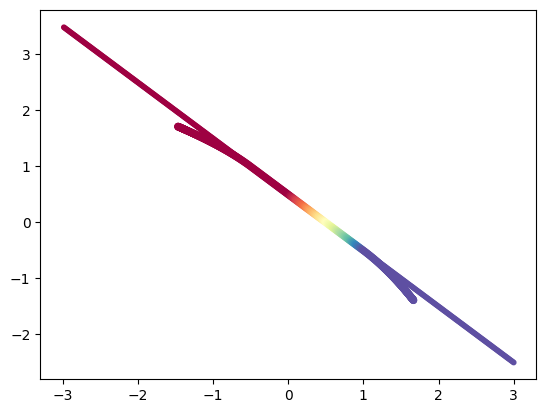

In [32]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def contract(pts):
    # pts should have shape [n_samples, 2]
    norms = torch.linalg.vector_norm(pts, ord=np.inf, dim=-1, keepdim=True).expand(-1, 2)  # [n_rays, n_samples, 3]
    norm_mask = norms > 1
    pts[norm_mask] = (2.0 - 1.0 / norms[norm_mask]) * pts[norm_mask] / norms[norm_mask]
    return pts

def make_line(m, b):
    x = torch.linspace(-3, 3, 400)
    y = m*x + b
    pts = torch.zeros(400, 2)
    pts[:,0] = x
    pts[:,1] = y
    return pts

pts = make_line(-1, 0.5)
idx = torch.linspace(-3, 3, 400)
cmap = matplotlib.cm.get_cmap('Spectral')
plt.scatter(pts[:,0], pts[:,1], c=cmap(idx), s=10)
contracted = contract(pts)
plt.scatter(contracted[:,0], contracted[:,1], c=cmap(idx), s=20)